In [25]:
import os
import pandas as pd
import numpy as np

import librosa
import matplotlib.pyplot as plt

from IPython.display import Audio
# !pip install pydub
from pydub import AudioSegment, effects
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras import layers, optimizers, callbacks
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
RAVDESS = "./Ravdess/audio_speech_actors_01-24/"
# CREMA = "/kaggle/input/cremad/AudioWAV/"
# TESS = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
# SAVEE = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

In [3]:
root_dir = "./Ravdess"

# Recursively search for .DS_Store files and delete them
for root, dirs, files in os.walk(root_dir):
    for file in files:
        if file == ".DS_Store":
            file_path = os.path.join(root, file)
            os.remove(file_path)
            print(f"{file_path} has been deleted.")

print("Deletion process completed.")


Deletion process completed.


In [4]:
ravdess_dir_lis = os.listdir(RAVDESS)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    '03' : 'happy',
    '01' : 'neutral',
    '04' : 'sad',
    '05' : 'angry',
    '06' : 'fear',
    '07' : 'disgust',
}

for directory in ravdess_dir_lis:
    actor_files = os.listdir(os.path.join(RAVDESS, directory))
    for audio_file in actor_files: 
        part = audio_file.split('.')[0]
        key = part.split('-')[2]
        if key in emotion_dic:
            gender_code = int(part.split('-')[6])
            path_list.append(f"{RAVDESS}{directory}/{audio_file}")
            gender_list.append('female' if gender_code & 1 == 0 else 'male')
            emotion_list.append(emotion_dic[key])
            
ravdess_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

ravdess_df.head()

,path,sex,emotion
0,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,angry
1,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,fear
2,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,fear
3,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,angry
4,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,disgust


In [5]:
ravdess_df['path'][0]

'./Ravdess/audio_speech_actors_01-24/Actor_16/03-01-05-01-02-01-16.wav'

In [6]:
ravdess_df['emotion'].value_counts()

angry      192
fear       192
disgust    192
sad        192
happy      192
neutral     96
Name: emotion, dtype: int64

In [11]:
# !pip install librosa


plt.style.use('ggplot')

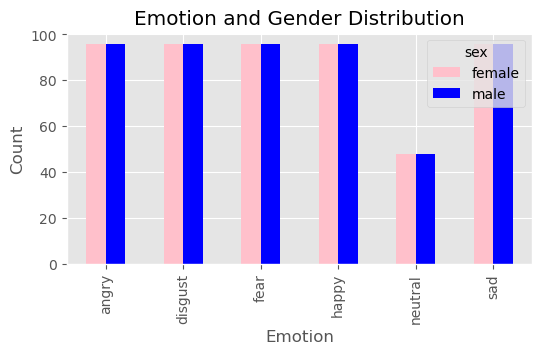

In [13]:
def plot_distribution(df): 
    countTable = df.groupby(['emotion', 'sex']).count()
    pivotTable = countTable.pivot_table(index='emotion', columns='sex', values='path')

    pivotTable.plot(kind='bar', figsize=(6, 3), color=['pink', 'blue'])
    plt.title('Emotion and Gender Distribution')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.show()
    
plot_distribution(ravdess_df)

In [14]:

def create_waveplot(y, sr, title):
    plt.figure(figsize=(8, 2))
    plt.title(title)
    librosa.display.waveshow(y, sr=sr)
    plt.show()

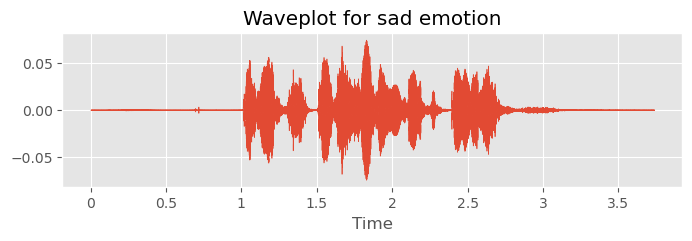

In [17]:
emotion_label = 'sad'
title = f"Waveplot for {emotion_label} emotion"
path = np.array(ravdess_df.path[ravdess_df.emotion == emotion_label])[1]
y, sr = librosa.load(path)

create_waveplot(y, sr, title)
Audio(path)

/Users/chandra/anaconda3/lib/python3.11/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [20]:
def preprocess_audio(path):
    _, sr = librosa.load(path)
    raw_audio = AudioSegment.from_file(path)
    
    samples = np.array(raw_audio.get_array_of_samples(), dtype='float32')
    trimmed, _ = librosa.effects.trim(samples, top_db=25)
    padded = np.pad(trimmed, (0, 180000-len(trimmed)), 'constant')
    return padded, sr

In [21]:
ravdess_df.head()

,path,sex,emotion
0,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,angry
1,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,fear
2,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,fear
3,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,angry
4,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,disgust


In [24]:
ravdess_df_rain = ravdess_df[ravdess_df['emotion']!='neutral'][['path','emotion']]
ravdess_df_rain

,path,emotion
0,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,angry
1,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,fear
2,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,fear
3,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,angry
4,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,disgust
...,...,...
1050,./Ravdess/audio_speech_actors_01-24/Actor_08/0...,disgust
1051,./Ravdess/audio_speech_actors_01-24/Actor_08/0...,disgust
1052,./Ravdess/audio_speech_actors_01-24/Actor_08/0...,sad
1053,./Ravdess/audio_speech_actors_01-24/Actor_08/0...,happy


In [27]:
emotion_dic = {
#     'neutral' : 0,
    'happy'   : 0,
    'sad'     : 1, 
    'angry'   : 2, 
    'fear'    : 3, 
    'disgust' : 4
}

def encode(label):
    return emotion_dic.get(label)

In [26]:
zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []

FRAME_LENGTH = 2048
HOP_LENGTH = 512

for row in ravdess_df_rain.itertuples(index=False):
    try: 
        y, sr = preprocess_audio(row.path)

        zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=HOP_LENGTH)

        zcr_list.append(zcr)
        rms_list.append(rms)
        mfccs_list.append(mfccs)

        emotion_list.append(encode(row.emotion))
    except:
        print(f"Failed for path: {row.path}")

Failed for path: ./Ravdess/audio_speech_actors_01-24/Actor_20/03-01-06-01-01-02-20.wav


In [27]:
X = np.concatenate((
    np.swapaxes(zcr_list, 1, 2), 
    np.swapaxes(rms_list, 1, 2), 
    np.swapaxes(mfccs_list, 1, 2)), 
    axis=2
)
X = X.astype('float32')

y = np.asarray(emotion_list)
y = np.expand_dims(y, axis=1).astype('int8')

In [30]:
# !pip install tensorflow

In [32]:
X_train, X_to_split, y_train, y_to_split = train_test_split(X, y, test_size=0.12, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_to_split, y_to_split, test_size=0.3, random_state=1)

y_train_class = to_categorical(y_train, 6)
y_val_class = to_categorical(y_val, 6)

In [34]:
MODEL = Sequential()
MODEL.add(layers.LSTM(64, return_sequences=True, input_shape=(X.shape[1:3])))
MODEL.add(layers.LSTM(64))
MODEL.add(layers.Dense(6, activation='softmax'))

print(MODEL.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 352, 64)           20480     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 53894 (210.52 KB)
Trainable params: 53894 (210.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [36]:
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.01, patience=100)
MODEL.compile(loss='categorical_crossentropy', optimizer='RMSProp', metrics=['categorical_accuracy'])
model = MODEL.fit(X_train, y_train_class, epochs=40, batch_size=6, validation_data=(X_val, y_val_class))

Epoch 1/40
141/141 [==============================] - 14s 89ms/step - loss: 0.8679 - categorical_accuracy: 0.6595 - val_loss: 1.2613 - val_categorical_accuracy: 0.5432
Epoch 2/40
141/141 [==============================] - 12s 86ms/step - loss: 0.8464 - categorical_accuracy: 0.6821 - val_loss: 1.3234 - val_categorical_accuracy: 0.5062
Epoch 3/40
141/141 [==============================] - 12s 87ms/step - loss: 0.8218 - categorical_accuracy: 0.6904 - val_loss: 1.3458 - val_categorical_accuracy: 0.4938
Epoch 4/40
141/141 [==============================] - 12s 87ms/step - loss: 0.7963 - categorical_accuracy: 0.6951 - val_loss: 1.3120 - val_categorical_accuracy: 0.5309
Epoch 5/40
141/141 [==============================] - 12s 86ms/step - loss: 0.8782 - categorical_accuracy: 0.6702 - val_loss: 1.4507 - val_categorical_accuracy: 0.4568
Epoch 6/40
141/141 [==============================] - 12s 87ms/step - loss: 0.8003 - categorical_accuracy: 0.6951 - val_loss: 1.3846 - val_categorical_accuracy:

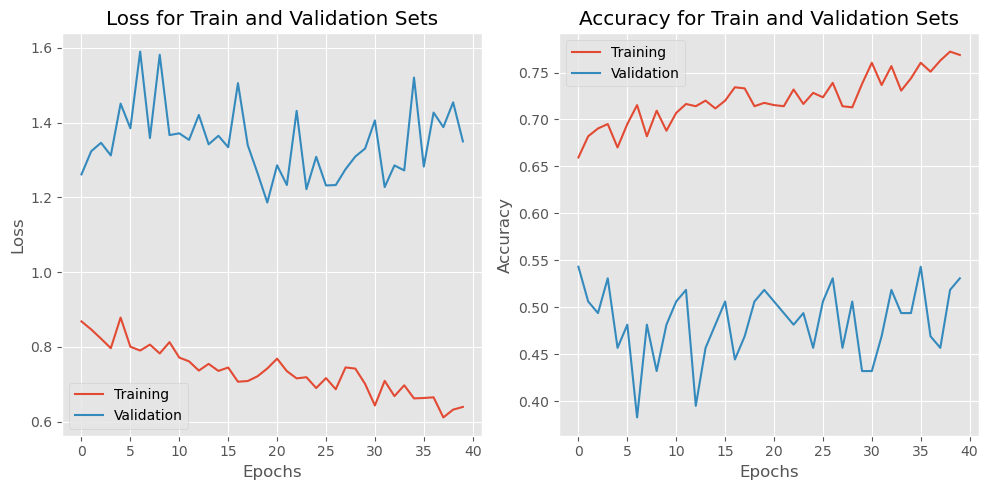

In [37]:

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(model.history['loss'])
axes[0].plot(model.history['val_loss'])
axes[0].set_title('Loss for Train and Validation Sets')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epochs')
axes[0].legend(['Training', 'Validation'])

axes[1].plot(model.history['categorical_accuracy'])
axes[1].plot(model.history['val_categorical_accuracy'])
axes[1].set_title('Accuracy for Train and Validation Sets')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].legend(['Training', 'Validation'])

fig.tight_layout()

plt.show()

3/3 [==============================] - 0s 30ms/step


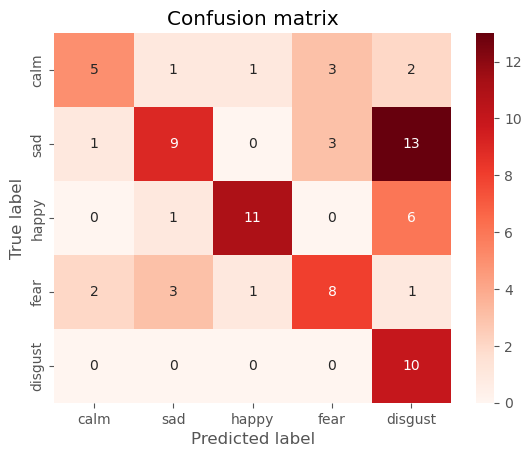

In [40]:

y_pred = np.argmax(MODEL.predict(X_val), axis=1)
labels = ['calm', 'sad', 'happy', 'fear', 'disgust']
cm = confusion_matrix(np.argmax(y_val_class, axis=1), y_pred, labels=range(5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

### Adding few more data from another resource : https://tspace.library.utoronto.ca/handle/1807/24487

In [54]:
root_dir = "./Ravdess"

# Recursively search for .DS_Store files and delete them
for root, dirs, files in os.walk(root_dir):
    for file in files:
        if file == ".DS_Store":
            file_path = os.path.join(root, file)
            os.remove(file_path)
            print(f"{file_path} has been deleted.")

print("Deletion process completed.")


./Ravdess/.DS_Store has been deleted.
./Ravdess/TESS Toronto emotional speech set data/.DS_Store has been deleted.
Deletion process completed.


In [55]:
TESS = './Ravdess/TESS Toronto emotional speech set data/'
tess_dir_list = os.listdir(TESS)
path_list = []
gender_list = []
emotion_list = [] 

emotion_dic = {
    'happy'   : 'happy',
    'neutral' : 'neutral',
    'sad'     : 'sad',
    'angry'   : 'angry',
    'fear'    : 'fear',
    'disgust'  : 'disgust',
}

for directory in tess_dir_list:
    audio_files = os.listdir(os.path.join(TESS, directory))
    for audio_file in audio_files:
        part = audio_file.split('.')[0]
        key = part.split('_')[2]
        if key in emotion_dic:
            path_list.append(f"{TESS}{directory}/{audio_file}") 
            gender_list.append('female') # female only dataset
            emotion_list.append(emotion_dic[key])
            
tess_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

tess_df.head()

,path,sex,emotion
0,./Ravdess/TESS Toronto emotional speech set da...,female,disgust
1,./Ravdess/TESS Toronto emotional speech set da...,female,disgust
2,./Ravdess/TESS Toronto emotional speech set da...,female,disgust
3,./Ravdess/TESS Toronto emotional speech set da...,female,disgust
4,./Ravdess/TESS Toronto emotional speech set da...,female,disgust


In [56]:
tess_df.shape

(2000, 3)

In [57]:
tess_df['path'][0]

'./Ravdess/TESS Toronto emotional speech set data/YAF_disgust/YAF_date_disgust.wav'

In [58]:
# df = pd.concat([ravdess_df,tess_df],axis=0)
# df.head()

In [59]:
df = pd.concat([ravdess_df, tess_df], axis=0).reset_index(drop=True)

In [60]:
df['path'][0]

'./Ravdess/audio_speech_actors_01-24/Actor_16/03-01-05-01-02-01-16.wav'

In [61]:
df['emotion'].value_counts()

angry      592
fear       592
disgust    592
sad        592
happy      592
neutral     96
Name: emotion, dtype: int64

In [62]:
df_train = df[df['emotion']!='neutral']
df_train

,path,sex,emotion
0,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,angry
1,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,fear
2,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,fear
3,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,angry
4,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,disgust
...,...,...,...
3051,./Ravdess/TESS Toronto emotional speech set da...,female,sad
3052,./Ravdess/TESS Toronto emotional speech set da...,female,sad
3053,./Ravdess/TESS Toronto emotional speech set da...,female,sad
3054,./Ravdess/TESS Toronto emotional speech set da...,female,sad


In [63]:
df_train['path'][0]

'./Ravdess/audio_speech_actors_01-24/Actor_16/03-01-05-01-02-01-16.wav'

In [64]:
zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []

FRAME_LENGTH = 2048
HOP_LENGTH = 512

for row in df_train.itertuples(index=False):
    try: 
        y, sr = preprocess_audio(row.path)

        zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=HOP_LENGTH)

        zcr_list.append(zcr)
        rms_list.append(rms)
        mfccs_list.append(mfccs)

        emotion_list.append(encode(row.emotion))
    except:
        print(f"Failed for path: {row.path}")

Failed for path: ./Ravdess/audio_speech_actors_01-24/Actor_20/03-01-06-01-01-02-20.wav


/Users/chandra/anaconda3/lib/python3.11/site-packages/pydub/utils.py:198: RuntimeWarning: Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work
  warn("Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work", RuntimeWarning)


Failed for path: ./Ravdess/TESS Toronto emotional speech set data/YAF_fear/YAF_neat_fear.wav


/Users/chandra/anaconda3/lib/python3.11/site-packages/pydub/utils.py:198: RuntimeWarning: Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work
  warn("Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work", RuntimeWarning)


Failed for path: ./Ravdess/TESS Toronto emotional speech set data/YAF_angry/YAF_germ_angry.wav


In [71]:
emotion_dic = {
#     'neutral' : 0,
    'happy'   : 0,
    'sad'     : 1, 
    'angry'   : 2, 
    'fear'    : 3, 
    'disgust' : 4
}

def encode(label):
    return emotion_dic.get(label)

In [72]:
# X.shape

In [73]:
# len(emotion_list)

In [74]:
y

array(['angry', 'fear', 'fear', ..., 'sad', 'sad', 'sad'], dtype='<U7')

In [69]:
# emotion_list

In [75]:
X = np.concatenate((
    np.swapaxes(zcr_list, 1, 2), 
    np.swapaxes(rms_list, 1, 2), 
    np.swapaxes(mfccs_list, 1, 2)), 
    axis=2
)
X = X.astype('float32')

mapped_emotions = [encode(emotion) for emotion in emotion_list]

y = np.asarray(mapped_emotions)
y = np.expand_dims(y, axis=1).astype('int8')

In [76]:
X_train, X_to_split, y_train, y_to_split = train_test_split(X, y, test_size=0.12, random_state=1,shuffle=True,)
X_val, X_test, y_val, y_test = train_test_split(X_to_split, y_to_split, test_size=0.3, random_state=1,shuffle=True,)

y_train_class = to_categorical(y_train, 5)
y_val_class = to_categorical(y_val, 5)

In [77]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(X.shape[1:3])),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 256)               278528    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 5)                

In [78]:
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.01, patience=3)
# MODEL.compile(loss='categorical_crossentropy', optimizer='RMSProp', metrics=['categorical_accuracy'])
model = model.fit(X_train, y_train_class, epochs=40, batch_size=32, validation_data=(X_val, y_val_class))


Epoch 1/40
82/82 [==============================] - 22s 258ms/step - loss: 1.5370 - accuracy: 0.2752 - val_loss: 1.4691 - val_accuracy: 0.3226
Epoch 2/40
82/82 [==============================] - 21s 253ms/step - loss: 1.3663 - accuracy: 0.3839 - val_loss: 1.3345 - val_accuracy: 0.4073
Epoch 3/40
82/82 [==============================] - 21s 256ms/step - loss: 1.2438 - accuracy: 0.4689 - val_loss: 1.1329 - val_accuracy: 0.5645
Epoch 4/40
82/82 [==============================] - 21s 258ms/step - loss: 1.1721 - accuracy: 0.5069 - val_loss: 1.0315 - val_accuracy: 0.6169
Epoch 5/40
82/82 [==============================] - 21s 253ms/step - loss: 1.1014 - accuracy: 0.5392 - val_loss: 1.0008 - val_accuracy: 0.6210
Epoch 6/40
82/82 [==============================] - 21s 253ms/step - loss: 1.0753 - accuracy: 0.5661 - val_loss: 0.9929 - val_accuracy: 0.6613
Epoch 7/40
82/82 [==============================] - 21s 252ms/step - loss: 1.0062 - accuracy: 0.5976 - val_loss: 0.9210 - val_accuracy: 0.6653

In [71]:
# MODEL = Sequential()
# MODEL.add(layers.LSTM(64, return_sequences=True, input_shape=(X.shape[1:3])))
# MODEL.add(layers.LSTM(64))
# MODEL.add(layers.Dense(5, activation='softmax'))

# print(MODEL.summary())

In [79]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

In [80]:
df_train

,path,sex,emotion
0,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,angry
1,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,fear
2,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,fear
3,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,angry
4,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,disgust
...,...,...,...
3051,./Ravdess/TESS Toronto emotional speech set da...,female,sad
3052,./Ravdess/TESS Toronto emotional speech set da...,female,sad
3053,./Ravdess/TESS Toronto emotional speech set da...,female,sad
3054,./Ravdess/TESS Toronto emotional speech set da...,female,sad


In [81]:
df_train['path'][0]

'./Ravdess/audio_speech_actors_01-24/Actor_16/03-01-05-01-02-01-16.wav'

In [95]:
extract_mfcc(tess_df['path'][0])

array([-4.4636795e+02,  7.3789307e+01,  1.5521693e+00,  4.0626900e+01,
       -8.4494514e+00, -2.9341414e+00, -6.6822000e+00, -1.7199314e+01,
       -5.6114135e+00, -1.3409514e+01, -7.3893251e+00,  6.8370895e+00,
       -1.0458899e+01,  3.2033212e+00, -1.0037674e+00, -5.6148562e+00,
        4.2504158e+00, -1.1169615e+00, -9.1154394e+00,  2.1831026e+00,
       -7.7419305e+00,  6.4608276e-01, -3.6939988e+00,  3.7297693e-01,
       -2.0016901e+00, -1.8217640e+00, -2.7837274e+00,  2.8430920e+00,
       -3.0322762e+00,  4.5028725e+00, -8.8744307e-01,  4.2168245e+00,
        1.7408369e+00,  3.8251708e+00,  4.3130198e+00,  3.1095665e+00,
        3.5192721e+00,  4.1317425e+00,  2.2578521e+00,  2.3055410e+00],
      dtype=float32)

In [96]:
X_mfcc = tess_df['path'].apply(lambda x: extract_mfcc(x))

In [97]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(2000, 40)

In [98]:
from sklearn.preprocessing import OneHotEncoder,StandardScaler
enc = OneHotEncoder()
y = enc.fit_transform(np.array(tess_df['emotion']).reshape(-1,1)).toarray()

In [99]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.2,shuffle=True)

In [100]:
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [101]:
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [102]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(x_train.shape[1],1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 256)               264192    
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 5)                

In [103]:
history = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=40, batch_size=16)


Epoch 1/40
100/100 [==============================] - 3s 26ms/step - loss: 0.7912 - accuracy: 0.6662 - val_loss: 0.3870 - val_accuracy: 0.8625
Epoch 2/40
100/100 [==============================] - 2s 24ms/step - loss: 0.3243 - accuracy: 0.8938 - val_loss: 0.2026 - val_accuracy: 0.9300
Epoch 3/40
100/100 [==============================] - 2s 24ms/step - loss: 0.2827 - accuracy: 0.8994 - val_loss: 0.2187 - val_accuracy: 0.9225
Epoch 4/40
100/100 [==============================] - 2s 25ms/step - loss: 0.2893 - accuracy: 0.9056 - val_loss: 0.2208 - val_accuracy: 0.9150
Epoch 5/40
100/100 [==============================] - 2s 25ms/step - loss: 0.1642 - accuracy: 0.9425 - val_loss: 0.1718 - val_accuracy: 0.9475
Epoch 6/40
100/100 [==============================] - 2s 25ms/step - loss: 0.1634 - accuracy: 0.9469 - val_loss: 0.1295 - val_accuracy: 0.9600
Epoch 7/40
100/100 [==============================] - 3s 26ms/step - loss: 0.1718 - accuracy: 0.9438 - val_loss: 0.1589 - val_accuracy: 0.9500

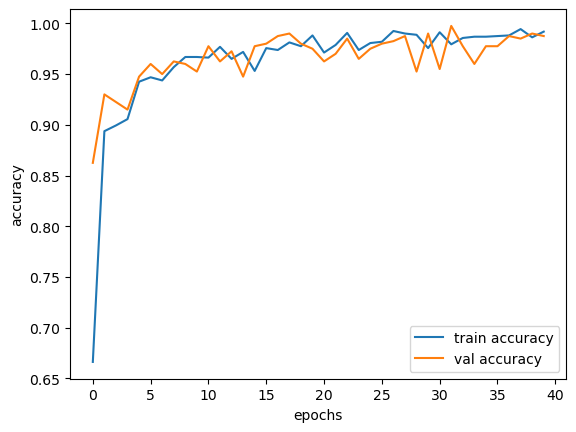

In [105]:
epochs = list(range(40))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

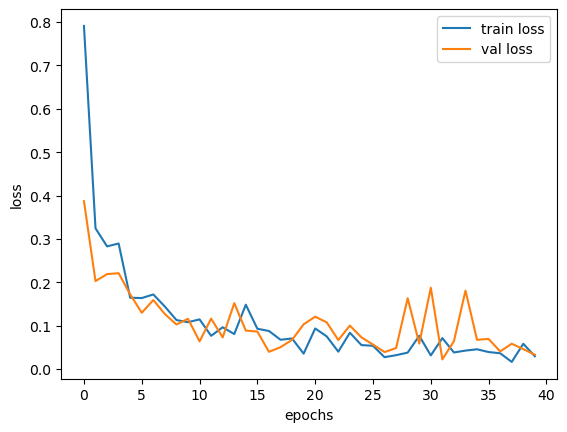

In [106]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [107]:
pred_test = model.predict(x_test)
y_pred = enc.inverse_transform(pred_test)

y_Test = enc.inverse_transform(y_test)

13/13 [==============================] - 0s 12ms/step


In [127]:
test = extract_mfcc(tess_df['path'][1])

In [128]:
test

array([-3.8337564e+02,  1.0815568e+02, -1.7578178e+01,  1.5888102e+01,
       -8.9548416e+00, -9.3803158e+00, -1.2016859e+01, -1.3081781e+01,
       -9.6609688e+00, -2.8669894e+00, -1.3426399e+01, -1.7332140e+00,
       -9.5570831e+00, -6.0779071e+00, -1.2656687e+00, -6.8803239e+00,
       -4.2504282e+00,  1.8667356e+00, -6.2409673e+00,  3.0240295e+00,
       -3.3475142e+00, -4.3196149e+00, -3.2732601e+00, -3.0325880e+00,
       -3.7847672e+00, -3.3011824e-01, -2.1876035e+00,  2.9914269e+00,
       -2.2106501e-01,  5.8534904e+00,  1.3559042e+00,  3.7682016e+00,
       -1.0988332e+00, -1.0929068e+00,  4.0544395e+00,  2.0253921e+00,
        4.9278936e+00,  4.3716860e+00,  1.7109394e+00,  5.5536609e+00],
      dtype=float32)

In [129]:
test = np.array(test)
test.shape

(40,)

In [136]:
test = scaler.transform(test.reshape(-1, 1))

ValueError: X has 1 features, but StandardScaler is expecting 40 features as input.

In [132]:
test = np.expand_dims(test, -1)


In [133]:
pred_test = model.predict(test)


1/1 [==============================] - 0s 19ms/step


In [134]:
pred_test

array([[9.2490664e-06, 9.9991822e-01, 6.3593798e-06, 2.8749510e-05,
        3.7364280e-05]], dtype=float32)

In [135]:
np.argmax(pred_test)

1

In [139]:
f3_mfcc=[]
extracted_features =[]
labels=[]
for row in df_train.itertuples(index=False):
    try: 
        _, sr = librosa.load(path = row.path, sr = None) 
        rawsound = AudioSegment.from_file(row.path) 
        normalizedsound = effects.normalize(rawsound, headroom = 0)
        normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')

        f3 = librosa.feature.mfcc(y=normal_x, sr=sr, n_mfcc=128)
        f3=np.mean(f3.T,axis=0)
        extracted_features.append([f3,row.emotion])
    except:
        print(f"Failed for path: {row.path}")

/Users/chandra/anaconda3/lib/python3.11/site-packages/pydub/utils.py:198: RuntimeWarning: Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work
  warn("Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work", RuntimeWarning)


Failed for path: ./Ravdess/TESS Toronto emotional speech set data/YAF_fear/YAF_neat_fear.wav


/Users/chandra/anaconda3/lib/python3.11/site-packages/pydub/utils.py:198: RuntimeWarning: Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work
  warn("Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work", RuntimeWarning)


Failed for path: ./Ravdess/TESS Toronto emotional speech set data/YAF_angry/YAF_germ_angry.wav


In [140]:
extracted_features = pd.DataFrame(extracted_features, columns=('features','op_labels'))
extracted_features.tail()

,features,op_labels
2953,"[725.5619, 74.31083, 30.649937, 19.612373, 12....",sad
2954,"[750.9414, 73.36872, 34.942028, 15.768087, 18....",sad
2955,"[751.8888, 88.171165, 27.160889, 9.597049, 14....",sad
2956,"[729.11884, 97.39985, 36.107143, 6.8423524, 6....",sad
2957,"[765.91595, 83.457405, 32.833126, 11.965522, 1...",sad


In [143]:
extracted_features.op_labels.value_counts()

disgust    592
sad        592
happy      592
angry      591
fear       591
Name: op_labels, dtype: int64

In [141]:
x=np.array(extracted_features['features'].tolist())
y=np.array(extracted_features['op_labels'].tolist())

In [142]:
print(x.shape,y.shape)

(2958, 128) (2958,)


In [144]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [146]:
y.shape

(2958, 5)

In [147]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.15,random_state=0)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(2514, 128) (444, 128) (2514, 5) (444, 5)


In [149]:
model=Sequential()
model.add(Dense(256,activation='relu',input_shape=(128,)))
model.add(Dense(256,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(5,activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy','Precision','Recall','AUC'])

In [173]:
model = Sequential()
model.add(LSTM(256, input_shape=(128,1)))  # LSTM layer added
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

In [174]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 256)               264192    
                                                                 
 dense_35 (Dense)            (None, 256)               65792     
                                                                 
 dense_36 (Dense)            (None, 256)               65792     
                                                                 
 dense_37 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 397061 (1.51 MB)
Trainable params: 397061 (1.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [175]:
model = model.fit(X_train,y_train,epochs=40,batch_size=16,validation_data=(X_test,y_test))

Epoch 1/40
158/158 [==============================] - 13s 80ms/step - loss: 1.5457 - accuracy: 0.2824 - precision: 0.7312 - recall: 0.0270 - auc: 0.6129 - val_loss: 1.5258 - val_accuracy: 0.3108 - val_precision: 0.4603 - val_recall: 0.1306 - val_auc: 0.6602
Epoch 2/40
158/158 [==============================] - 12s 78ms/step - loss: 1.5122 - accuracy: 0.3003 - precision: 0.5842 - recall: 0.0442 - auc: 0.6456 - val_loss: 1.4244 - val_accuracy: 0.3671 - val_precision: 0.7969 - val_recall: 0.1149 - val_auc: 0.6946
Epoch 3/40
158/158 [==============================] - 13s 80ms/step - loss: 1.4305 - accuracy: 0.3604 - precision: 0.7126 - recall: 0.0986 - auc: 0.6951 - val_loss: 1.4542 - val_accuracy: 0.3378 - val_precision: 0.5741 - val_recall: 0.1396 - val_auc: 0.6897
Epoch 4/40
158/158 [==============================] - 13s 80ms/step - loss: 1.3989 - accuracy: 0.3660 - precision: 0.6734 - recall: 0.1197 - auc: 0.7135 - val_loss: 1.3590 - val_accuracy: 0.4009 - val_precision: 0.7130 - val_r

KeyboardInterrupt: 

In [152]:
model.evaluate(X_train,y_train)

79/79 [==============================] - 0s 765us/step - loss: 0.0799 - accuracy: 0.9686 - precision: 0.9786 - recall: 0.9626 - auc: 0.9993


[0.07992735505104065,
 0.9685759544372559,
 0.9785685539245605,
 0.9626094102859497,
 0.9992848634719849]

In [153]:
model.evaluate(X_test,y_test)

14/14 [==============================] - 0s 1ms/step - loss: 0.3619 - accuracy: 0.8851 - precision: 0.9091 - recall: 0.8784 - auc: 0.9840


[0.36191123723983765,
 0.8851351141929626,
 0.9090909361839294,
 0.8783783912658691,
 0.9839894771575928]

In [154]:
extracted_features['op_labels'].unique()

array(['angry', 'fear', 'disgust', 'sad', 'happy'], dtype=object)

In [156]:
filename="./Ravdess/TESS Toronto emotional speech set data/OAF_angry/OAF_back_angry.wav"
data, i_sr =librosa.load(filename)
i_rawsound = AudioSegment.from_file(filename)
i_normalizedsound = effects.normalize(i_rawsound, headroom = 0)
i_normal_x = np.array(i_normalizedsound.get_array_of_samples(), dtype = 'float32')
i_f3 = librosa.feature.mfcc(y=i_normal_x, sr=i_sr, n_mfcc=128) # MFCC
i_f3=np.mean(i_f3.T,axis=0)
i_f3=i_f3.reshape(1,-1)
predicted_label=model.predict(i_f3)
a=np.argmax(predicted_label,axis=1)
b=labelencoder.inverse_transform(a)
print(b[0])

1/1 [==============================] - 0s 34ms/step
angry


TypeError: 'dict' object is not callable

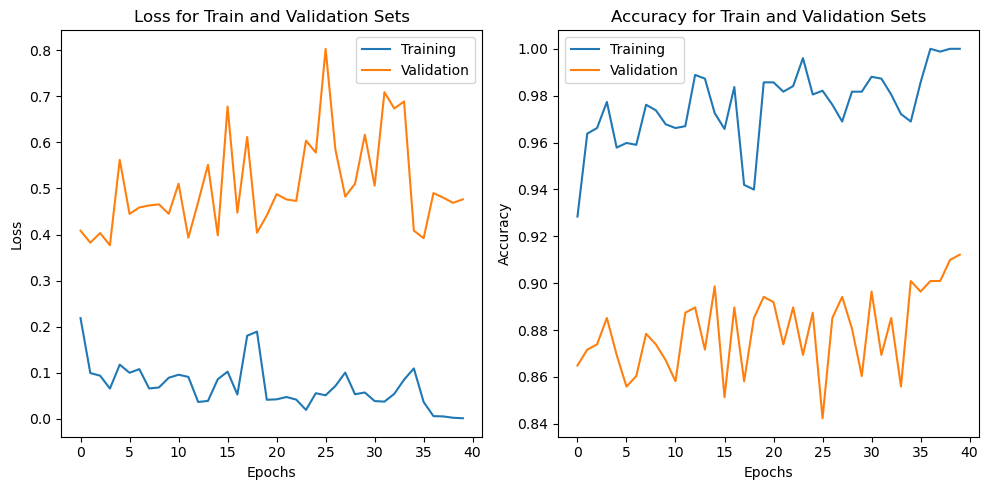

In [162]:

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(model.history['loss'])
axes[0].plot(model.history['val_loss'])
axes[0].set_title('Loss for Train and Validation Sets')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epochs')
axes[0].legend(['Training', 'Validation'])

axes[1].plot(model.history['accuracy'])
axes[1].plot(model.history['val_accuracy'])
axes[1].set_title('Accuracy for Train and Validation Sets')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].legend(['Training', 'Validation'])

fig.tight_layout()

plt.show()

In [ ]:
can we apply LSTM

In [ ]:
model.save('emotion detection through speech-2.9.h5')

In [178]:
import platform
import subprocess
def get_mac_serial_number():
    if platform.system() == 'Darwin':
        command = "ioreg -l | awk '/IOPlatformSerialNumber/ { print $4;}'"
        serial_number = str(subprocess.check_output(command, shell=True))[2:-3]
        return serial_number
    else:
        return "Serial number retrieval not supported for this operating system."

# Call the function to get the Mac serial number
serial_number = get_mac_serial_number()
print("Mac Serial Number:", serial_number)


Mac Serial Number: "PV6CG2Y0W2"


In [177]:
# !pip install subprocess

ERROR: Could not find a version that satisfies the requirement subprocess (from versions: none)
ERROR: No matching distribution found for subprocess
